## 1. Chargement et Préparation des Données

### 1.1 Importation des données

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


### 1.2 Load and Merge Data (Charger et Fusionner les Données)
Objectif : Charger tous les fichiers CSV, puis fusionner les données sur EmployeeID.

In [78]:

employee_df = pd.read_csv("data/employee_survey_data.csv")
general_df = pd.read_csv("data/general_data.csv")
manager_df = pd.read_csv("data/manager_survey_data.csv")
in_time_df = pd.read_csv("data/in_time.csv")
out_time_df = pd.read_csv("data/out_time.csv")

# Merge employee_df and general_df on EmployeeID
merged_df = pd.merge(employee_df, general_df, on="EmployeeID", how="inner")

# Merge in manager_df
merged_df = pd.merge(merged_df, manager_df, on="EmployeeID", how="inner")


# Afficher un aperçu
print(merged_df.head())


   EmployeeID  EnvironmentSatisfaction  ...  JobInvolvement  PerformanceRating
0           1                      3.0  ...               3                  3
1           2                      3.0  ...               2                  4
2           3                      2.0  ...               3                  3
3           4                      4.0  ...               2                  3
4           5                      4.0  ...               3                  3

[5 rows x 29 columns]


### 1.3 Drop Irrelevant Columns (Supprimer les Colonnes Inutiles)
Objectif : Supprimer les colonnes qui n'apportent pas d'informations utiles à l'analyse.
#### Colonnes à supprimer :
- Over18 : Tous les employés ont plus de 18 ans.
- EmployeeCount : Toujours égal à 1 (inutile).
- StandardHours : Toujours égal à 8 (inutile).

In [79]:
# Supprimer les colonnes inutiles
columns_to_drop = ["EmployeeCount", "Over18", "StandardHours"]
merged_df.drop(columns=columns_to_drop, axis=1, inplace=True, errors="ignore")
# Visualiser apres suppression de quelques colonnes
print(merged_df.head())


   EmployeeID  EnvironmentSatisfaction  ...  JobInvolvement  PerformanceRating
0           1                      3.0  ...               3                  3
1           2                      3.0  ...               2                  4
2           3                      2.0  ...               3                  3
3           4                      4.0  ...               2                  3
4           5                      4.0  ...               3                  3

[5 rows x 26 columns]


### 1.4 Clean up and Prepare Time Data (Nettoyage et Préparation des Données de Temps)
Objectif : Transformer les fichiers in_time et out_time pour obtenir le nombre d'heures travaillées.

#### Actions :
- Convertir les dates en format datetime.
- Calculer la durée travaillée chaque jour (out_time - in_time).
- Calculer la moyenne des heures travaillées pour chaque employé.

In [80]:
# Rename 'Unnamed: 0' to 'EmployeeID' for easier merging
in_time_df.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)
out_time_df.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)

# We’ll create a separate DataFrame that holds each employee’s average work hours
# Convert time columns to datetime (ignore errors if any NaNs or incorrect formats appear)
time_cols = in_time_df.columns[1:]  # skip EmployeeID column
in_time_df[time_cols] = in_time_df[time_cols].apply(pd.to_datetime, errors="coerce")
out_time_df[time_cols] = out_time_df[time_cols].apply(pd.to_datetime, errors="coerce")

# Calculate the daily hours as OUT - IN
# This returns a DataFrame of timedeltas; convert to hours by dividing total_seconds by 3600
daily_hours = out_time_df[time_cols].sub(in_time_df[time_cols])
daily_hours = daily_hours.apply(lambda row: row.dt.total_seconds() / 3600)

# Create average hours feature per employee
avg_hours_df = pd.DataFrame({
    "EmployeeID": in_time_df["EmployeeID"],
    "AverageWorkHours": daily_hours.mean(axis=1)  # mean across all days
})

# Merge avg_hours_df with merged_df
merged_df = pd.merge(merged_df, avg_hours_df, on="EmployeeID", how="left")

print(merged_df[["EmployeeID", "AverageWorkHours"]].head())


   EmployeeID  AverageWorkHours
0           1          7.373651
1           2          7.718969
2           3          7.013240
3           4          7.193678
4           5          8.006175


### 1.5 Merge Time Features Back (Fusionner les Données de Temps dans le Dataset Principal)
**Objectif** : Ajouter la colonne AverageWorkHours au dataset fusionné.

In [81]:
# Fusionner les données de temps avec le dataset principal
final_df = pd.merge(merged_df, avg_hours_df, on="EmployeeID", how="left")

# Vérifier les mises à jour
print(final_df.head())


   EmployeeID  EnvironmentSatisfaction  ...  AverageWorkHours_x  AverageWorkHours_y
0           1                      3.0  ...            7.373651            7.373651
1           2                      3.0  ...            7.718969            7.718969
2           3                      2.0  ...            7.013240            7.013240
3           4                      4.0  ...            7.193678            7.193678
4           5                      4.0  ...            8.006175            8.006175

[5 rows x 28 columns]


### 1.6 Create or Transform Other Meaningful Features (Créer ou Transformer des Variables Intéressantes)
**Objectif** : Transformer les variables en formats exploitables pour l’analyse et les modèles.

#### Transformations importantes :
Encodage de Attrition : Convertir Yes/No en 1/0.
Remplacer les valeurs manquantes (NA) dans employee_survey_data.csv par la médiane.
Encodage des variables catégorielles (BusinessTravel, EducationField, etc.).
Création d'une variable YearsSinceLastPromotionRatio : YearsSinceLastPromotion / YearsAtCompany.

In [82]:
# Transformer la colonne 'Attrition' en variable binaire
final_df["Attrition"] = final_df["Attrition"].map({"No": 0, "Yes": 1})

# Remplacer les valeurs manquantes par la médiane dans employee_survey_data
for col in ["EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance"]:
    final_df[col].fillna(final_df[col].median(), inplace=True)

# Encodage des variables catégorielles avec pandas get_dummies
final_df = pd.get_dummies(final_df, columns=["BusinessTravel", "EducationField", "MaritalStatus", "JobRole"], drop_first=True)

# Créer une variable 'YearsSinceLastPromotionRatio'
final_df["YearsSinceLastPromotionRatio"] = final_df["YearsSinceLastPromotion"] / (final_df["YearsAtCompany"] + 1)

# Vérifier les mises à jour
print(final_df.head())


   EmployeeID  ...  YearsSinceLastPromotionRatio
0           1  ...                      0.000000
1           2  ...                      0.166667
2           3  ...                      0.000000
3           4  ...                      0.777778
4           5  ...                      0.000000

[5 rows x 42 columns]


C:\Users\hamza\AppData\Local\Temp\ipykernel_38772\3592201222.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df[col].fillna(final_df[col].median(), inplace=True)
C:\Users\hamza\AppData\Local\Temp\ipykernel_38772\3592201222.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

## Préparation des Données
### 1. Gestion des valeurs manquantes

In [83]:
# Vérifier les valeurs manquantes
final_df.isnull().sum()

# Imputer les valeurs manquantes pour les variables numériques avec la médiane
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# Sélection des colonnes numériques

## à Compléter
df_num = final_df.select_dtypes(include=float)
imputer.fit(df_num)
## à Compléter

# Remplacement des valeurs manquantes
df_num_imputed = pd.DataFrame(imputer.transform(df_num), columns=df_num.columns)

# Vérifier s'il reste des valeurs manquantes
df_num_imputed.isnull().sum()

EnvironmentSatisfaction         0
JobSatisfaction                 0
WorkLifeBalance                 0
NumCompaniesWorked              0
TotalWorkingYears               0
AverageWorkHours_x              0
AverageWorkHours_y              0
YearsSinceLastPromotionRatio    0
dtype: int64

### 2. Encodage des variables catégorielles

In [84]:
# Sélection des colonnes catégorielles
df_cat = final_df.select_dtypes(include=[object])

# Encodage one-hot des variables catégorielles

## à Compléter
df_cat_encoded = pd.get_dummies(df_cat)
## à Compléter 

# Vérification du résultat de l'encodage
df_cat_encoded.head()

,Department_Human Resources,Department_Research & Development,Department_Sales,Gender_Female,Gender_Male
0,False,False,True,True,False
1,False,True,False,True,False
2,False,True,False,False,True
3,False,True,False,False,True
4,False,True,False,False,True


### 3. Normalization des données

In [85]:
# Normalisation des colonnes numériques
scaler = StandardScaler()
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num_imputed), columns=df_num_imputed.columns)

# Vérification de la normalisation
df_num_scaled.head()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked,TotalWorkingYears,AverageWorkHours_x,AverageWorkHours_y,YearsSinceLastPromotionRatio
0,0.252200,1.156302,-1.085336,-0.678464,-1.322079,-0.244123,-0.244123,-0.878153
1,0.252200,-0.663899,1.757749,-1.079486,-0.678877,0.013564,0.013564,-0.259189
2,-0.665460,-0.663899,-2.506879,-0.678464,-0.807517,-0.513073,-0.513073,-0.878153
3,1.169861,1.156302,0.336206,0.123580,0.221606,-0.378424,-0.378424,2.010349
4,1.169861,-1.573999,0.336206,0.524602,-0.292956,0.227886,0.227886,-0.878153


### 4. Assemblage des données préparées

In [86]:
# Concatenation des colonnes numériques normalisées et des colonnes catégorielles encodées
df_prepared = pd.concat([df_num_scaled, df_cat_encoded], axis=1)
df_prepared["Attrition"] = df["Attrition"]
# Vérification des données préparées
df_prepared.head()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked,TotalWorkingYears,AverageWorkHours_x,AverageWorkHours_y,YearsSinceLastPromotionRatio,Department_Human Resources,Department_Research & Development,Department_Sales,Gender_Female,Gender_Male,Attrition
0,0.252200,1.156302,-1.085336,-0.678464,-1.322079,-0.244123,-0.244123,-0.878153,False,False,True,True,False,0
1,0.252200,-0.663899,1.757749,-1.079486,-0.678877,0.013564,0.013564,-0.259189,False,True,False,True,False,1
2,-0.665460,-0.663899,-2.506879,-0.678464,-0.807517,-0.513073,-0.513073,-0.878153,False,True,False,False,True,0
3,1.169861,1.156302,0.336206,0.123580,0.221606,-0.378424,-0.378424,2.010349,False,True,False,False,True,0
4,1.169861,-1.573999,0.336206,0.524602,-0.292956,0.227886,0.227886,-0.878153,False,True,False,False,True,0


### 5. Séparation des caractéristiques (X) et de la cible (y)

In [87]:
# Séparation des caractéristiques et de la cible
X = df_prepared.drop(["Attrition"], axis = 1)
y = df_prepared["Attrition"]

# Vérification des dimensions
print(X.shape)
print(y.shape)

(4410, 13)
(4410,)


## Exploration et Visualisation des Données

### 1. Analyse des Statistiques Descriptives

Avant de plonger dans la visualisation des données, examinons les statistiques descriptives pour obtenir une première idée des distributions des variables.

### 2. Tests d'ANOVA & X2
write something

### 3. Visualisation des Variables Numériques
Nous commencerons par visualiser les distributions des variables numériques pour mieux comprendre leurs comportements.

### 3. Matrice de Corrélation
Pour explorer les relations entre les variables numériques, nous utilisons une matrice de corrélation et une heatmap.

### 4. Visualisation des Relations entre les Variables
Nous allons créer quelques graphes de dispersion pour visualiser les relations entre certaines variables clés.

### 5. Analyse de la Variable Cible
Analysons la variable cible Sold6M pour voir comment elle est distribuée.

### 6. Relations entre les Variables et la Cible
Examinons comment certaines variables influencent la probabilité de vendre un bien immobilier dans les 6 mois.

## Modèles de Classification
Dans cette section, nous allons créer et évaluer plusieurs modèles de classification afin de prédire... (ici on met des definitions rapide et insights sur les modeles (interpretabilité vs performance...))

## Application des modèles
### 0. Préparation des données d'apprentissage et de test

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [89]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1323 entries, 3662 to 4
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EnvironmentSatisfaction            1323 non-null   float64
 1   JobSatisfaction                    1323 non-null   float64
 2   WorkLifeBalance                    1323 non-null   float64
 3   NumCompaniesWorked                 1323 non-null   float64
 4   TotalWorkingYears                  1323 non-null   float64
 5   AverageWorkHours_x                 1323 non-null   float64
 6   AverageWorkHours_y                 1323 non-null   float64
 7   YearsSinceLastPromotionRatio       1323 non-null   float64
 8   Department_Human Resources         1323 non-null   bool   
 9   Department_Research & Development  1323 non-null   bool   
 10  Department_Sales                   1323 non-null   bool   
 11  Gender_Female                      1323 non-null   bool   
 1

### 1. Régression Logistique

Ici, ajouter plusieurs cellules (entrainement, evaluation, optimisation, explicabilité)

Matrice de Confusion (Régression Logistique) :
 [[1091   19]
 [ 181   32]]
Rapport de Classification (Régression Logistique) :
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      1110
           1       0.63      0.15      0.24       213

    accuracy                           0.85      1323
   macro avg       0.74      0.57      0.58      1323
weighted avg       0.82      0.85      0.81      1323

AUC-ROC (Régression Logistique) :
 0.5665588123334602


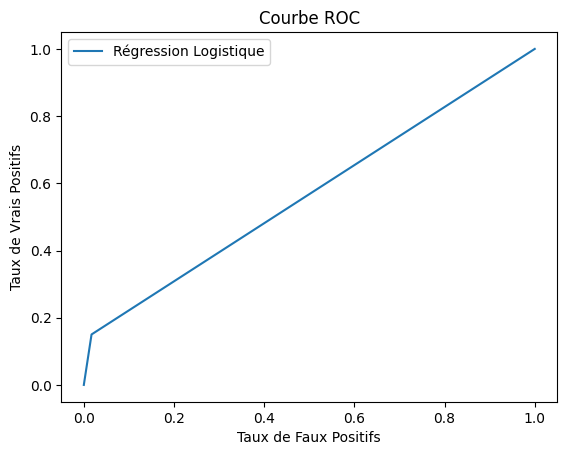

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Initialisation et entraînement du modèle

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

# Prédictions
y_pred_log_reg = log_reg.predict(X_test)

# Matrice de confusion
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("Matrice de Confusion (Régression Logistique) :\n", conf_matrix_log_reg)

# Rapport de classification
class_report_log_reg = classification_report(y_test, y_pred_log_reg)
print("Rapport de Classification (Régression Logistique) :\n", class_report_log_reg)

# AUC-ROC
roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)
print("AUC-ROC (Régression Logistique) :\n", roc_auc_log_reg)

# Courbe ROC
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label="Régression Logistique")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

### 2. Random Forest

Ici, ajouter plusieurs cellules (entrainement, evaluation, optimisation, explicabilité)

Matrice de Confusion (Random Forest) :
 [[1109    1]
 [  28  185]]
Rapport de Classification (Random Forest) :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1110
           1       0.99      0.87      0.93       213

    accuracy                           0.98      1323
   macro avg       0.98      0.93      0.96      1323
weighted avg       0.98      0.98      0.98      1323

AUC-ROC (Random Forest) :
 0.9338218500190331


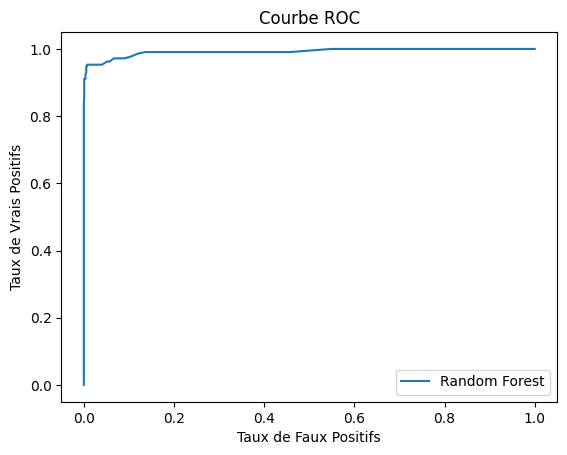

In [92]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation et entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Matrice de confusion
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Matrice de Confusion (Random Forest) :\n", conf_matrix_rf)

# Rapport de classification
class_report_rf = classification_report(y_test, y_pred_rf)
print("Rapport de Classification (Random Forest) :\n", class_report_rf)

# AUC-ROC
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
print("AUC-ROC (Random Forest) :\n", roc_auc_rf)

# Courbe ROC
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

# Etude comparative entre les modèles

## Interprétation des Résultats
### 1. Analyse des Performances

## Conclusion
### 1. Synthèse des Travaux Réalisés